In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from retrieve_preprocessed_dataset import *

In [ ]:
# retrieve_dataset (x recuperare da locale retrieve_prepro_dataset) - lables_thresholds - retrieve_sequeces -
# pre_processing - correlations - feature_selection - PCA (TSNE doesnt work)

### Label

Labels of enhancers remain strongly unbalance, even with dropping. Almost all values of enhancers labels are 0 (third quartile is 0).

I decided to set promoters threshold equal to 1 and don't drop values between 0 and 1 because this improve balance between classes but not enough to eliminate samples from the dataset. 
About enhancers the threshold is set to 0 because this leads classes to be as balanced as possible.

I'm not focusing on the biological meaning of my choices, the threshold are chosen to obtain a dataset useful for learning. 

In [2]:
epigenomes, labels, sequences = retrieve_preprocessed_dataset()

### Features distribution

In [7]:
from sklearn.metrics.pairwise import euclidean_distances

In [8]:
def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

Top 5 different features from promoters.


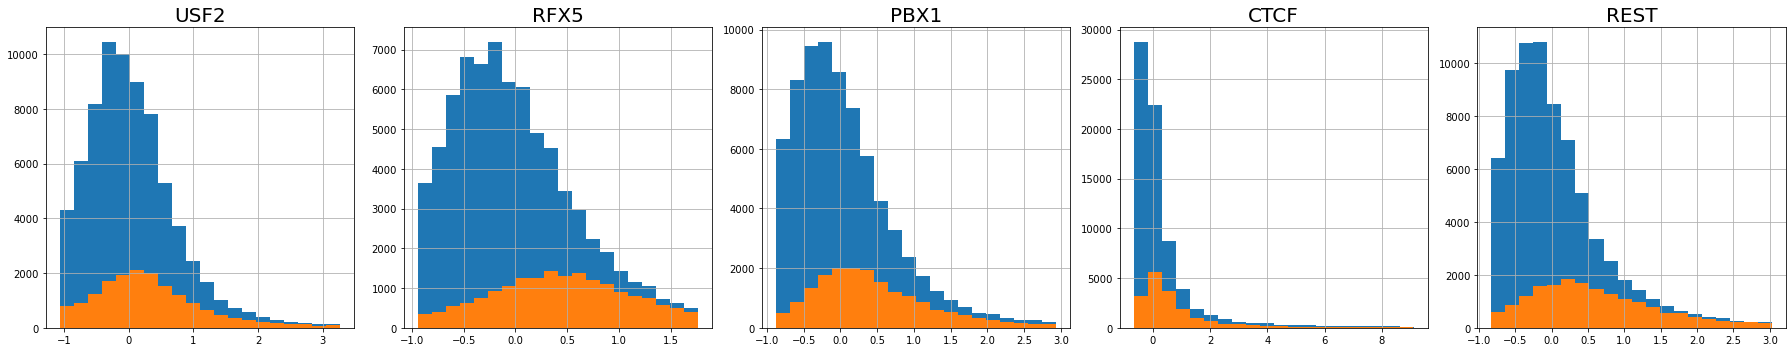

Top 5 different features from enhancers.


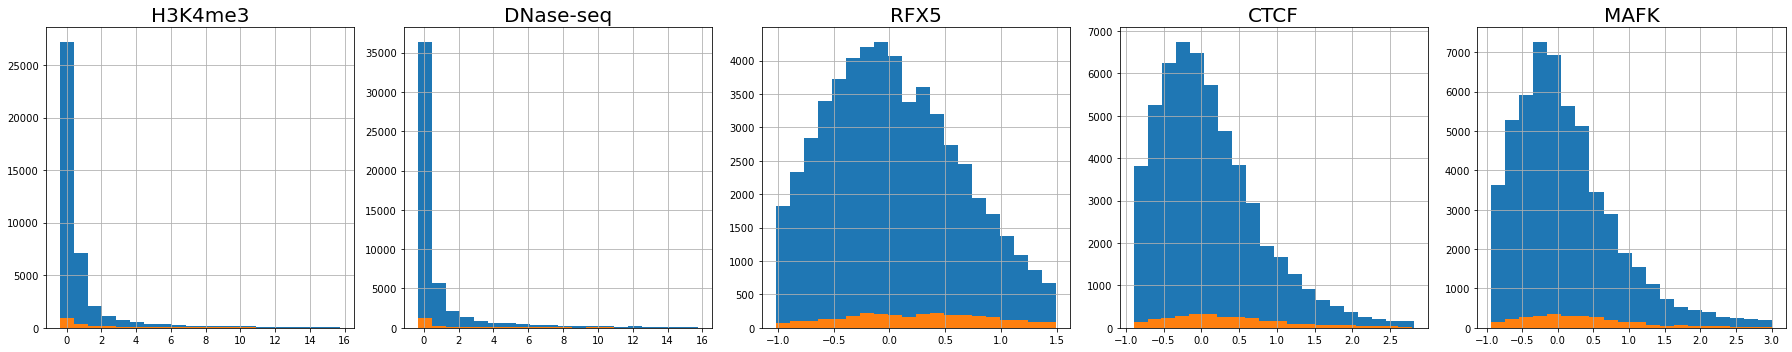

In [16]:
top_number = 5

for region, x in epigenomes.items():
    dist = euclidean_distances(x.T)
    most_distance_columns_indices = get_top_most_different(dist, top_number)
    columns = x.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features from {region}.")
    for column, axis in zip(columns, axes.flatten()):
        head, tail = x[column].quantile([0.05, 0.95]).values.ravel()
        
        mask = ((x[column] < tail) & (x[column] > head)).values
        
        cleared_x = x[column][mask]
        cleared_y = labels[region].values.ravel()[mask]
        
        cleared_x[cleared_y==0].hist(ax=axis, bins=20)
        cleared_x[cleared_y==1].hist(ax=axis, bins=20)

        axis.set_title(column, fontsize=20)
    fig.tight_layout()
    plt.savefig(f'.\\img\\features_distribution_{region}.jpg')
    plt.show()


## MODEL

In [3]:
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from extra_keras_metrics import get_complete_binary_metrics
from tensorflow import keras

In [4]:
def build_perceptron(input_shape: int)-> Model:

    input_epigenomic_data = Input(shape = (input_shape,), name = "epigenomic_data")
    output = Dense(1, activation = "sigmoid")(input_epigenomic_data)

    perceptron = Model(
        inputs = input_epigenomic_data,
        outputs = output,
        name = "perc"
    ) 

    perceptron.compile(
        optimizer = "nadam",
        loss = "binary_crossentropy",
        metrics = get_complete_binary_metrics()
    )
    
    return perceptron

In [82]:
# SEQUENTIAL

def build_sequential_ffnn(input_shape:int) -> Model:
    
    input_epigenomic_data = Input(shape = (input_shape,), name = "epigenomic_data")
    
    ffnn = Sequential([
        input_epigenomic_data,
        Dense(64, activation = 'relu'),
        Dense(32, activation="relu"),
        Dropout(rate = 0.3),
        Dense(32, activation="relu"),
        Dropout(rate = 0.3),
        Dense(1, activation="sigmoid")
    ])
    
    ffnn.compile(
        optimizer = "nadam", 
        loss = "binary_crossentropy", 
        metrics = get_complete_binary_metrics())
    
    return ffnn

In [85]:
# FUNCTIONAL 

def build_ffnn(input_shape:int) -> Model:
 
    input_epigenomic_data = Input(shape = (input_shape,), name = "epigenomic_data")
    hidden = Dense(64, activation = 'relu')(input_epigenomic_data)
    
    for _ in range(2):
        hidden = Dense(32, activation="relu")(hidden)
        hidden = Dropout(rate = 0.3)(hidden)
    
    output = Dense(1, activation='sigmoid')(hidden)
    
    ffnn = Model(
        inputs = input_epigenomic_data, 
        outputs = output,
        name = 'FFNN')
    
    ffnn.compile(
        optimizer = "nadam", 
        loss = "binary_crossentropy", 
        metrics = get_complete_binary_metrics())
    
    return ffnn

------------------

## Training

In [78]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

# aumentare numero di splits (10)
number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits = number_of_splits,
    test_size = 0.2
)

In [30]:
# X = np.array([1,  2,  3,  4,  5,  6,  7,  8,  9])
# y = np.array([10, 11, 12, 12, 13, 14, 15, 16, 17])

# a = MixedSequence(
        
#         x = {"epigenomic_data": VectorSequence(X, 2)},
        
#         y = VectorSequence(y, 2)
#     )
# a[0]

In [8]:
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence

def get_ffnn_sequence(X: np.ndarray, y: np.ndarray, batch_size: int = 1024) -> MixedSequence:

    return MixedSequence(
        
        x = {"epigenomic_data": VectorSequence(X, batch_size)},
        
        y = VectorSequence(y, batch_size)
    )


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(
    model: Model,
    model_name: str,
    task: str,
    train_sequence,
    test_sequence,
    holdout_number: int) -> Tuple[pd.DataFrame, pd.DataFrame]:

    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data = test_sequence,
        epochs = 10,
        verbose = False,
        callbacks = [EarlyStopping("loss", min_delta = 0.001, patience = 2, mode = "min"),]).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose = False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose = False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

In [15]:
all_binary_classification_performance = []

training_histories = {}

for region, X in epigenomes.items():

    y = labels[region]
    training_histories[region] = []

    number_of_features = X.shape[1]
    
    for holdout_index, (train_indices, test_indices) in enumerate(holdouts_generator.split(X, y)):
        
        train_X, test_X = X.iloc[train_indices].values , X.iloc[test_indices].values 
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
          
        perceptron = build_perceptron(number_of_features)
        ffnn = build_ffnn(number_of_features)

        train_ffnn_sequence = get_ffnn_sequence(train_X, train_y)
        test_ffnn_sequence = get_ffnn_sequence(test_X, test_y)
        
        for model, train_sequence, test_sequence in [
            (perceptron,  train_ffnn_sequence, test_ffnn_sequence),
            (ffnn, train_ffnn_sequence, test_ffnn_sequence)
        ]:
            
            print('task on ' + str(region) + " - " + str(holdout_index + 1) + " holdout - model: " + model.name)
        
            history, performance = train_model(
                    model,
                    model.name,
                    task = region,
                    train_sequence = train_sequence,
                    test_sequence = test_sequence,
                    holdout_number = holdout_index
                )

            all_binary_classification_performance.append(performance)
    print("-"*80)
        
all_binary_classification_performance = pd.concat(all_binary_classification_performance)        

task on promoters - 1 holdout - model: perc
task on promoters - 1 holdout - model: FFNN
task on promoters - 2 holdout - model: perc
task on promoters - 2 holdout - model: FFNN
--------------------------------------------------------------------------------
task on enhancers - 1 holdout - model: perc
task on enhancers - 1 holdout - model: FFNN
task on enhancers - 2 holdout - model: perc
task on enhancers - 2 holdout - model: FFNN
--------------------------------------------------------------------------------


Rendering barplots:   0%|                                                                       | 0/27 [00:00<…

((<Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure si

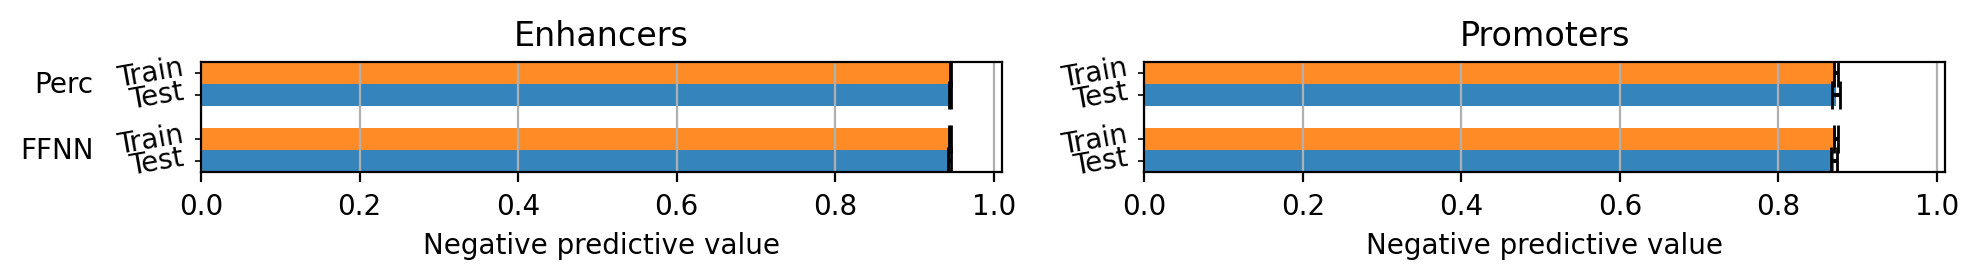

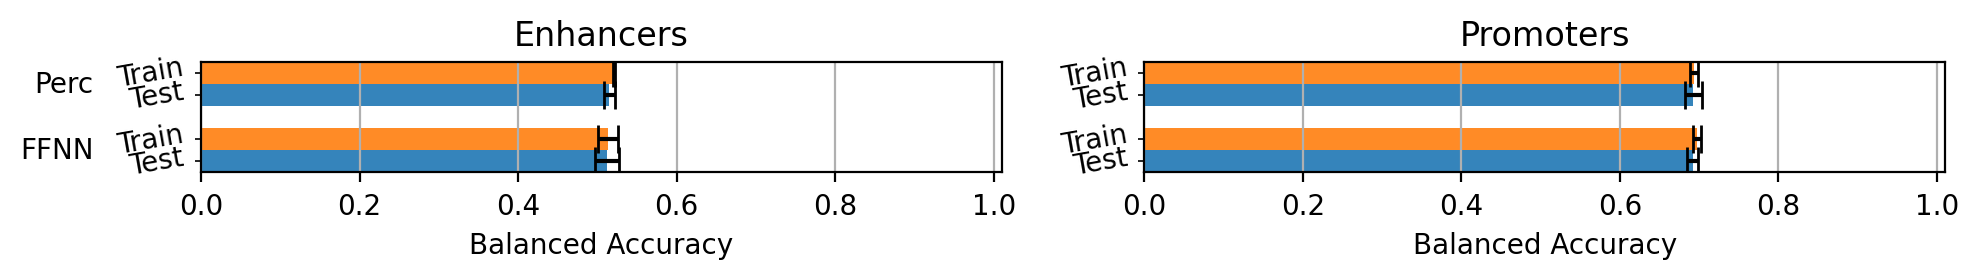

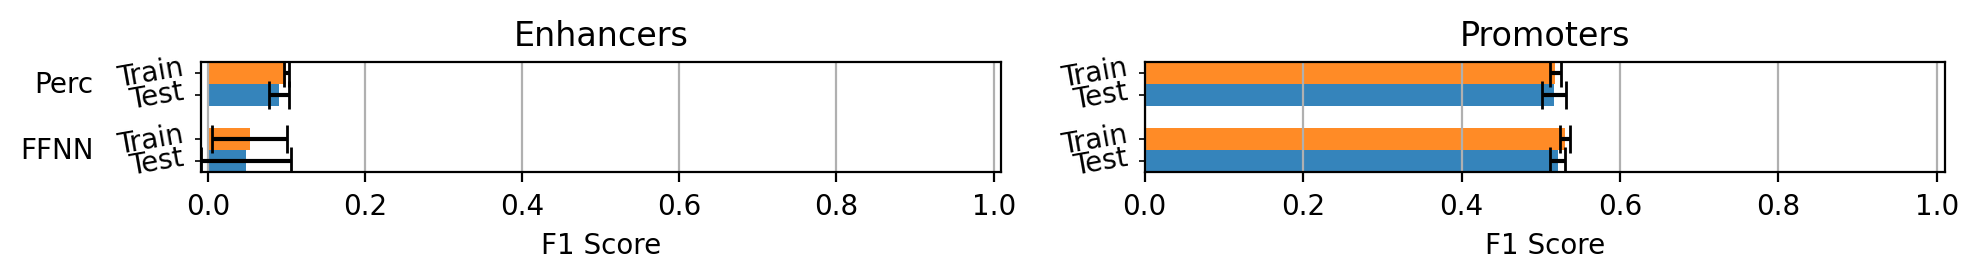

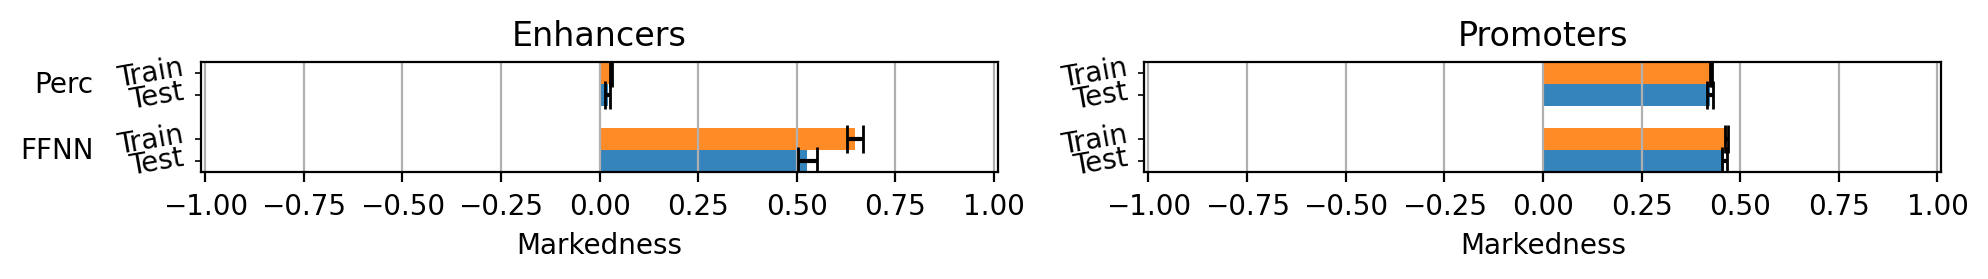

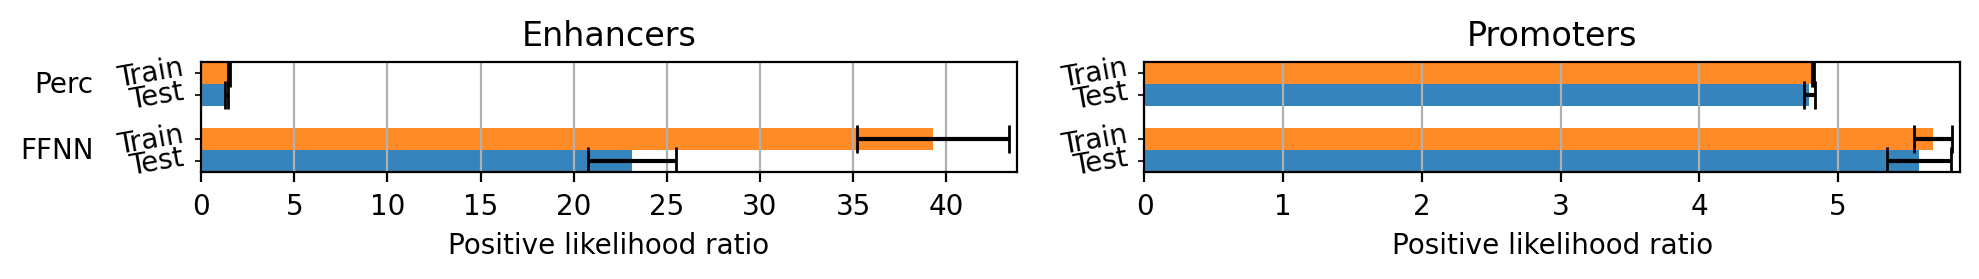

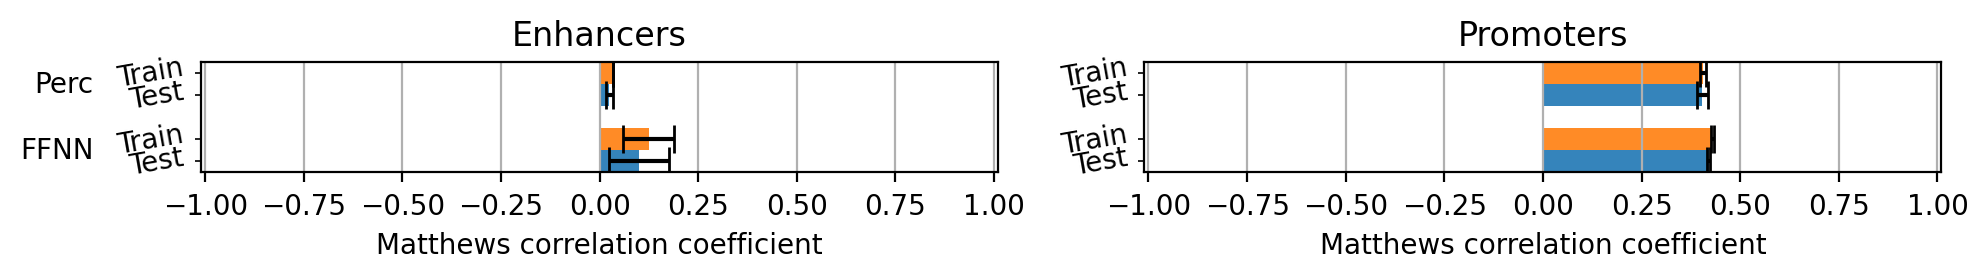

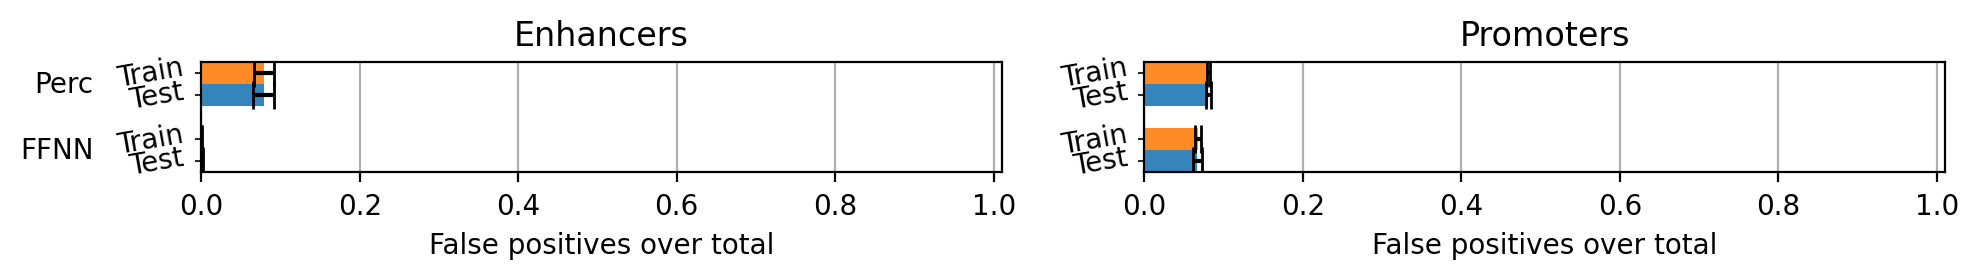

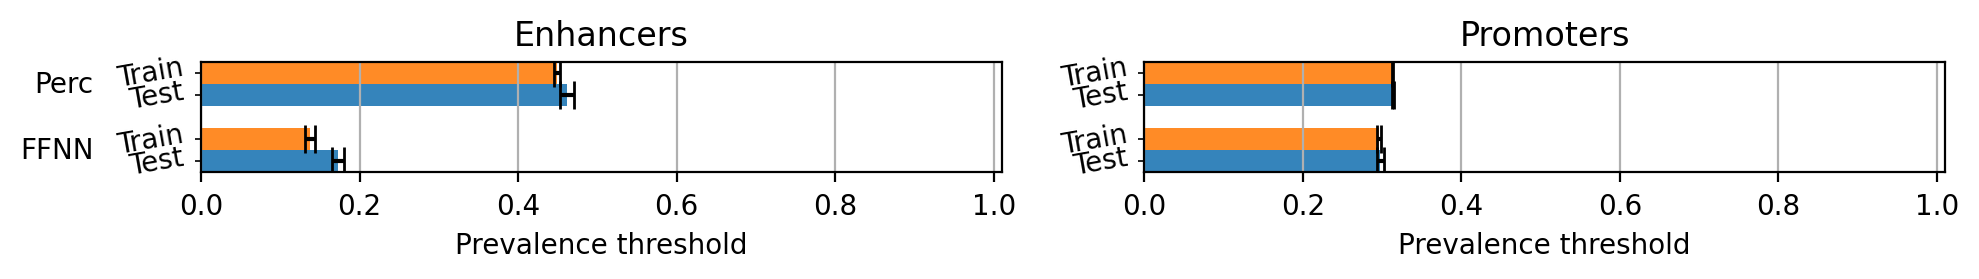

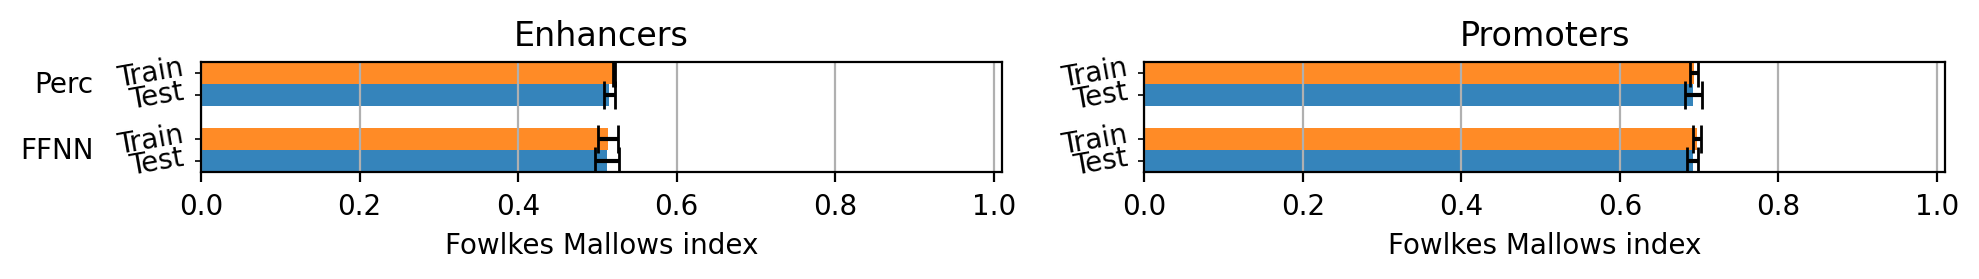

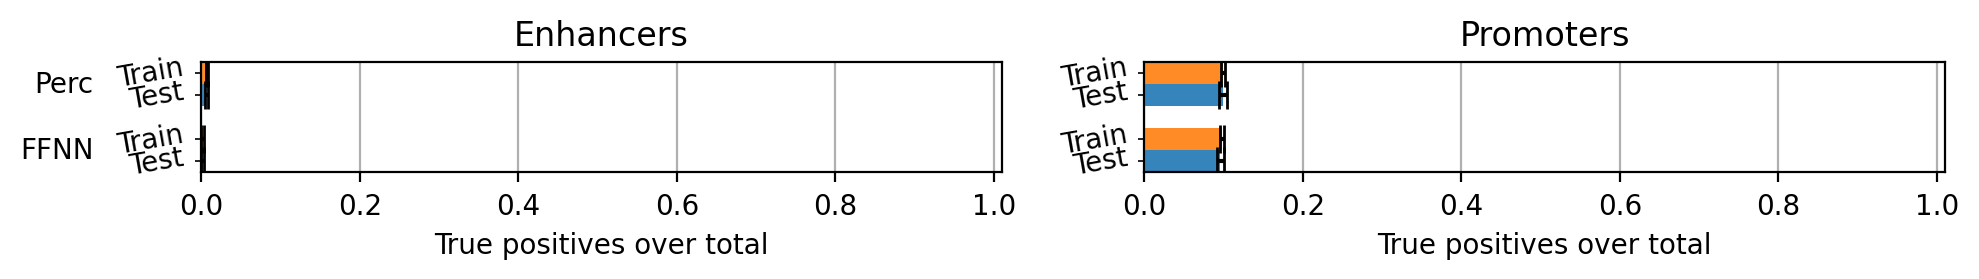

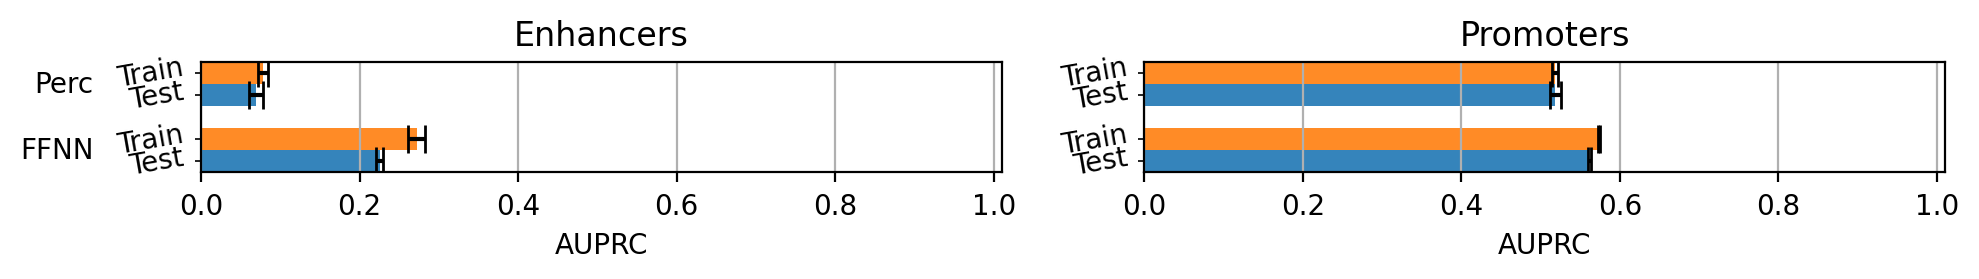

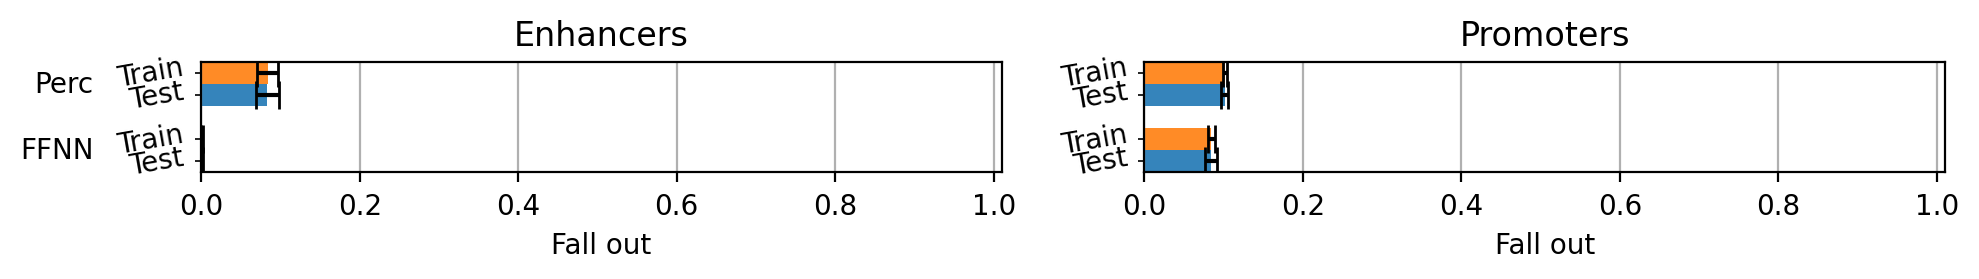

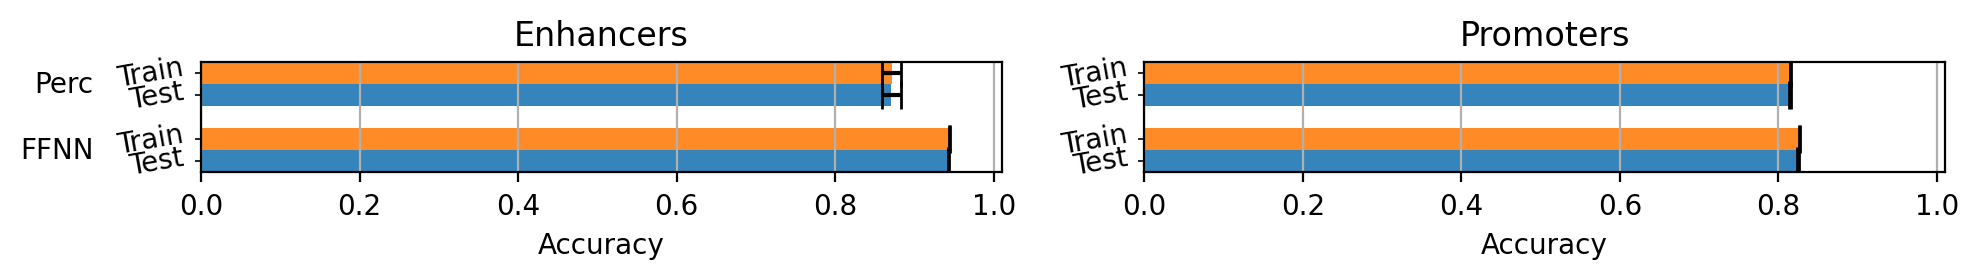

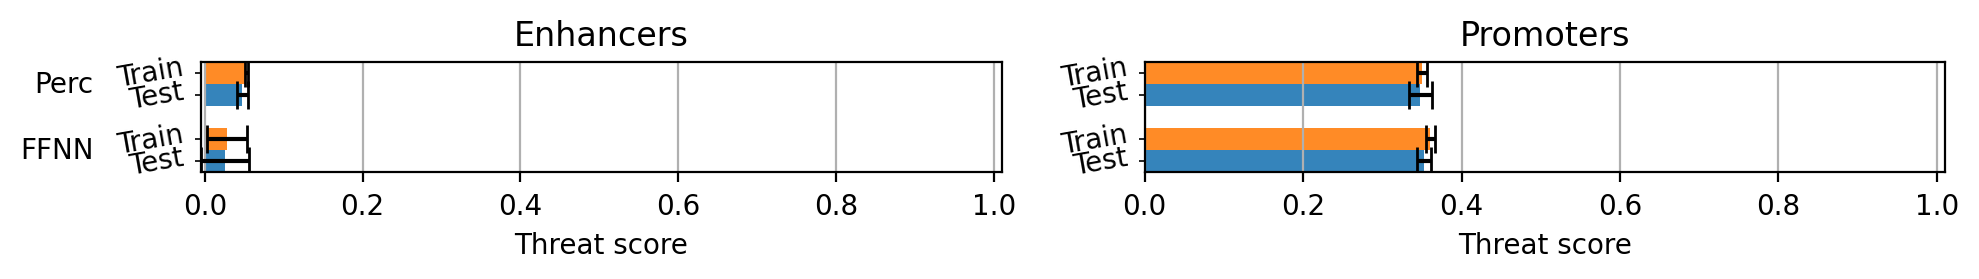

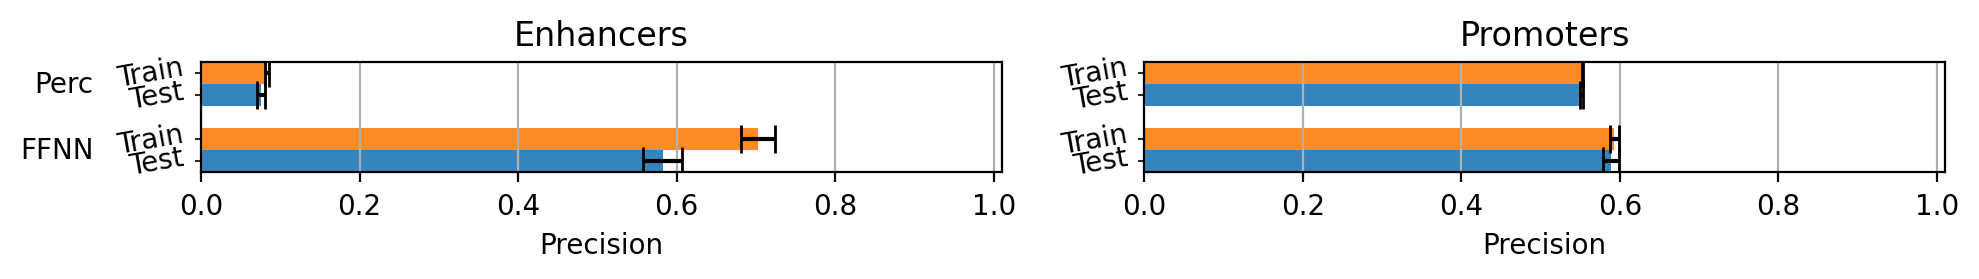

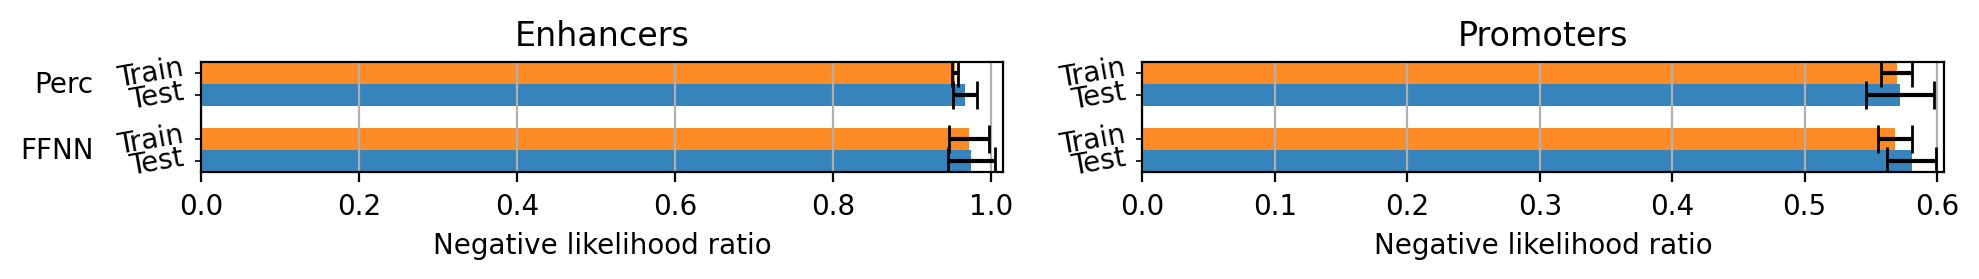

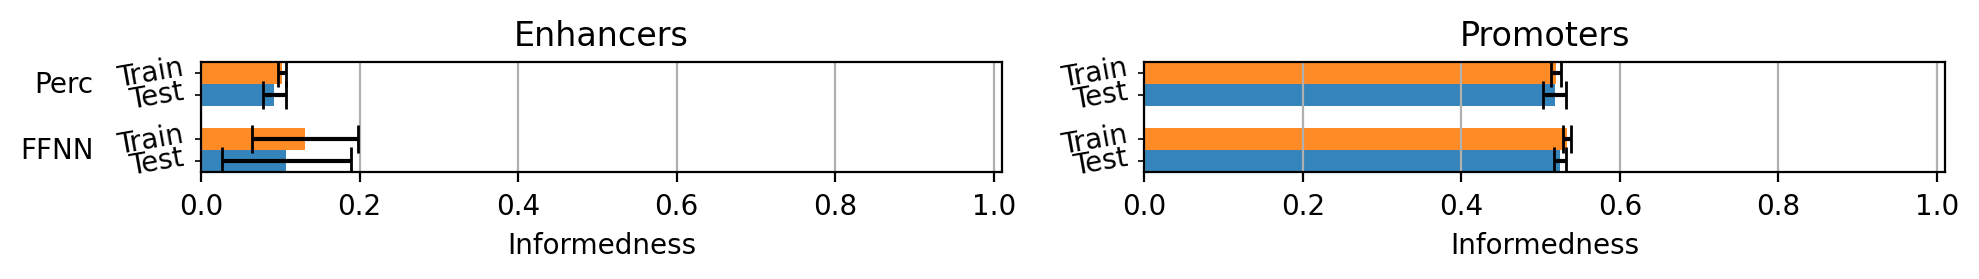

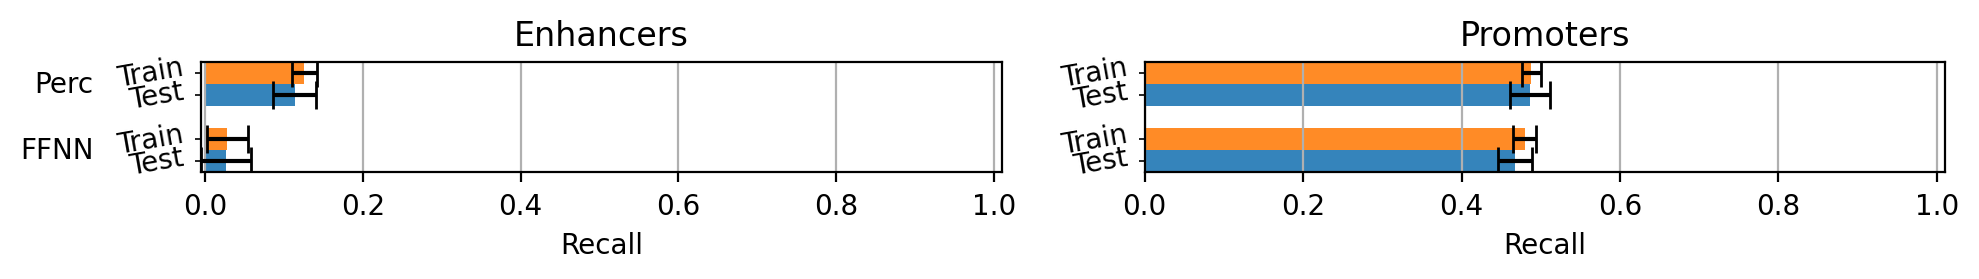

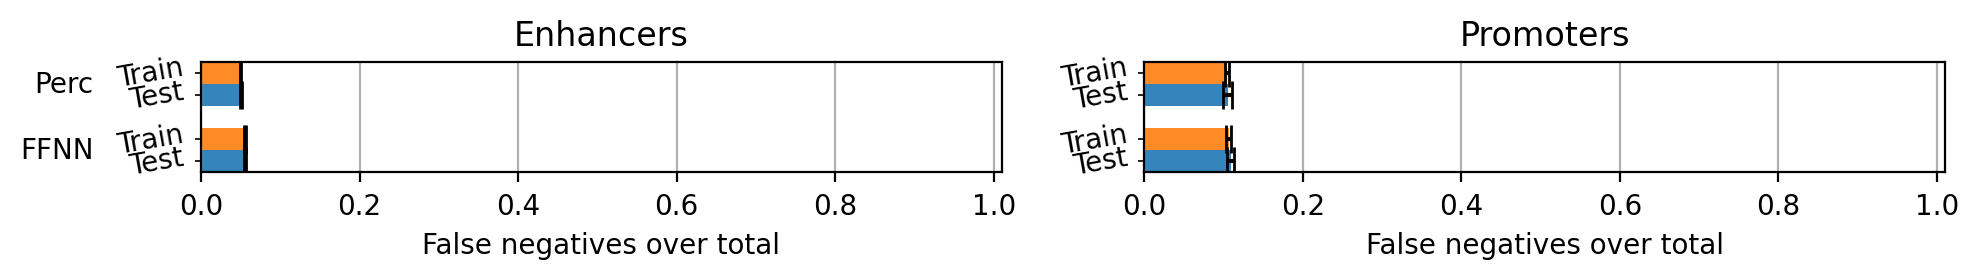

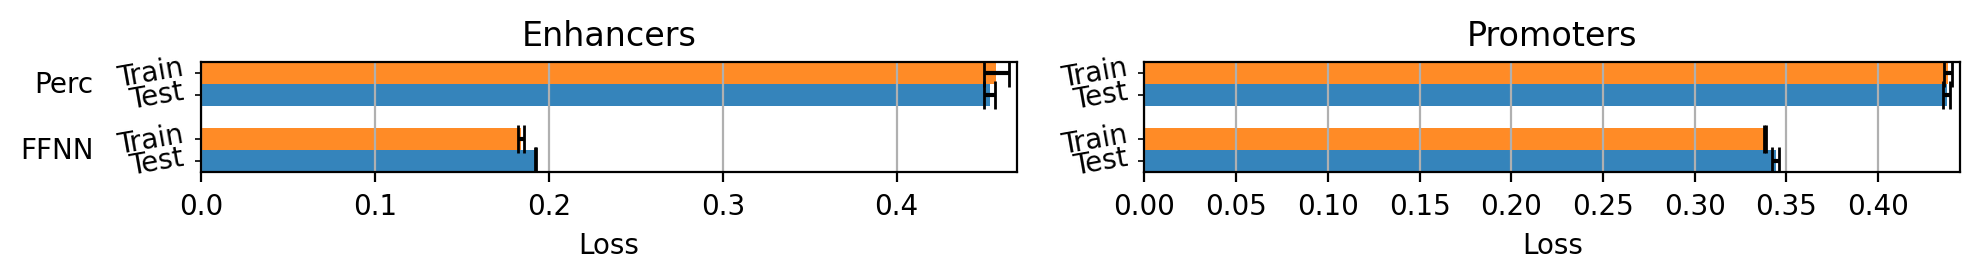

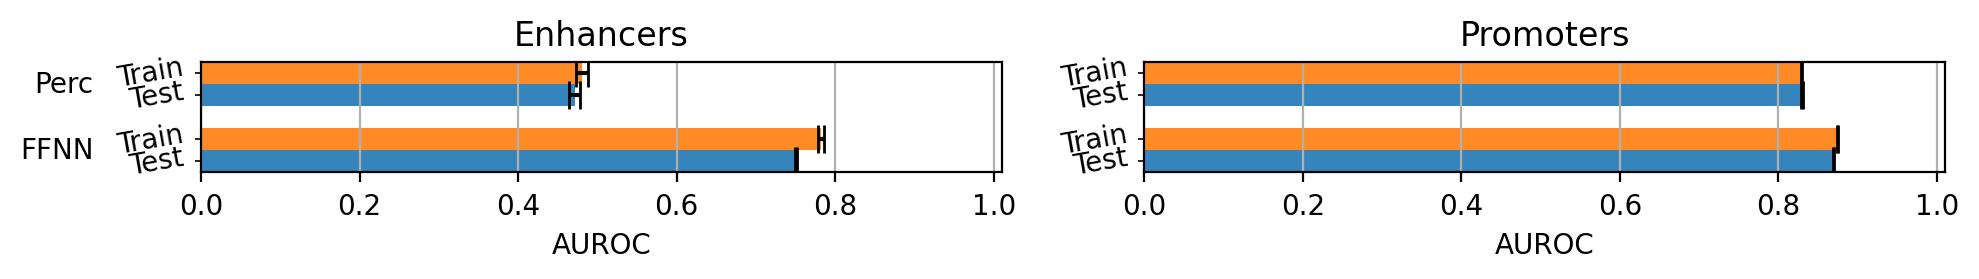

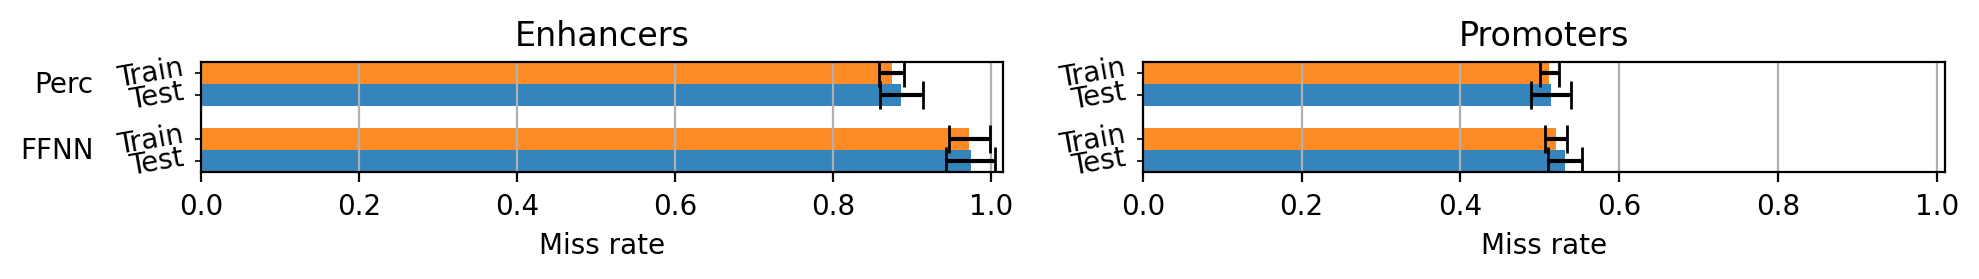

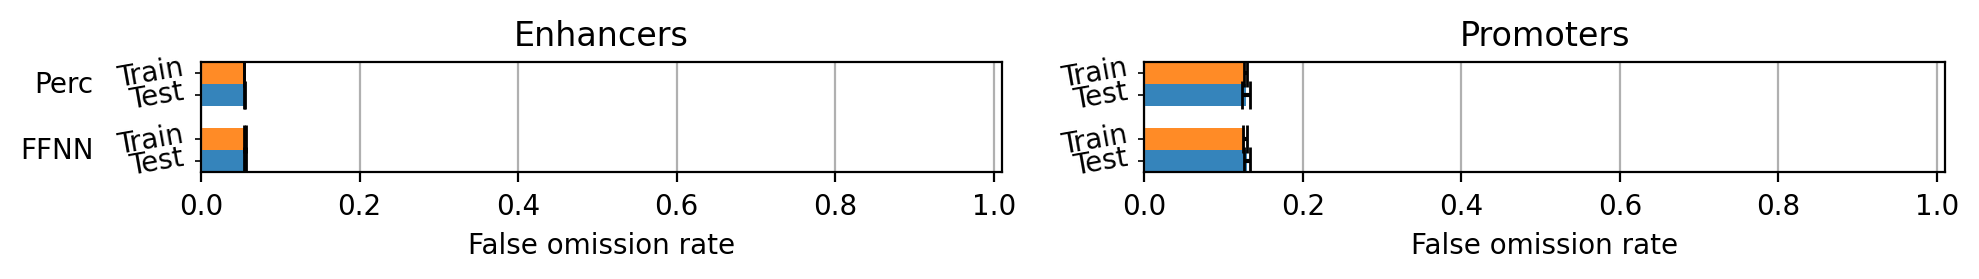

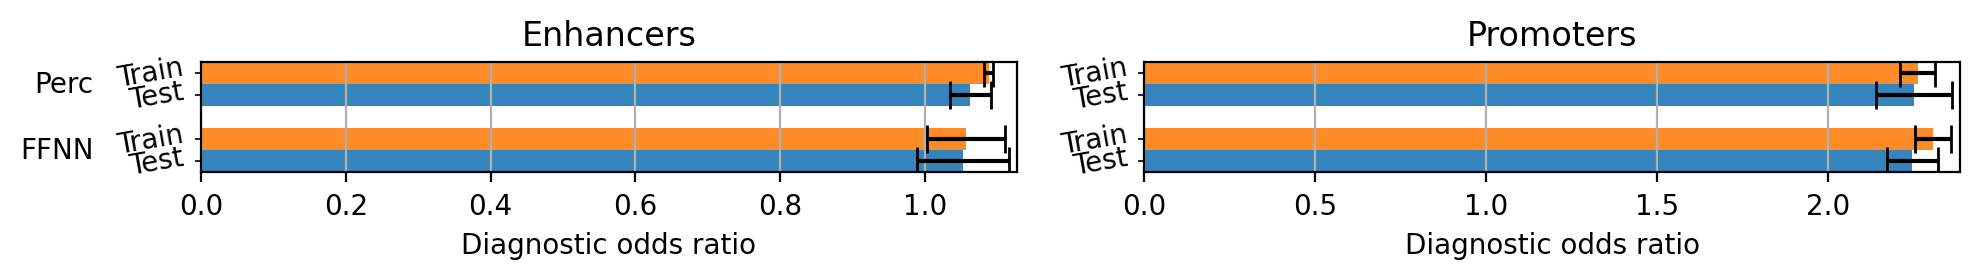

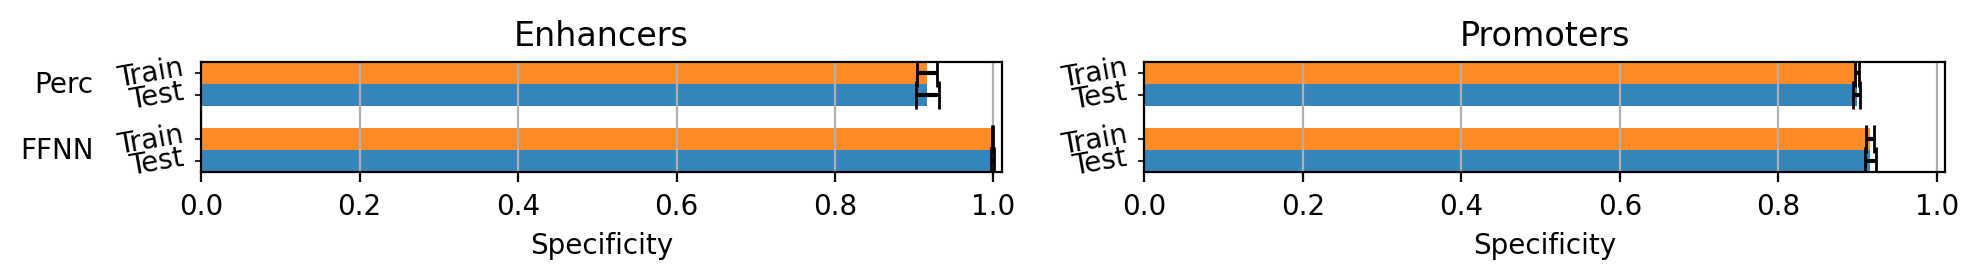

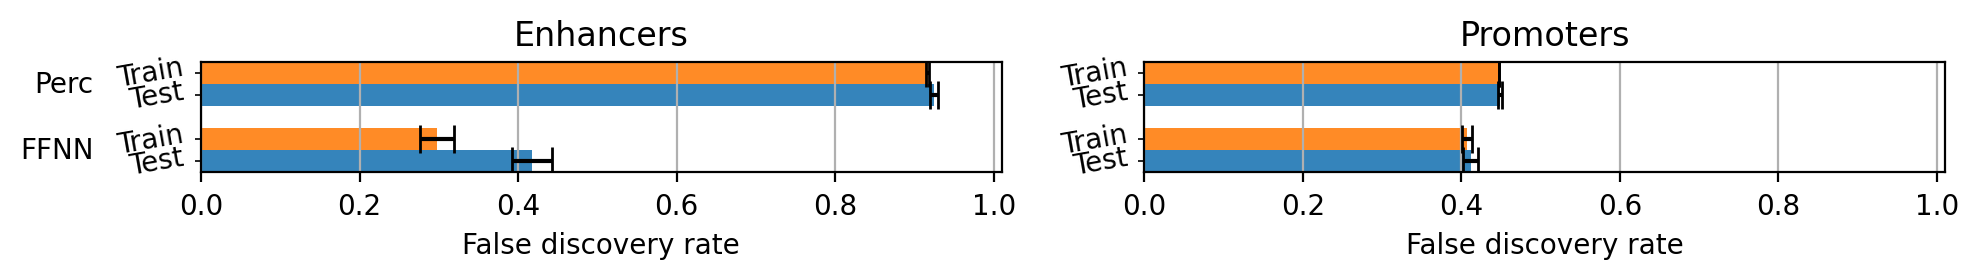

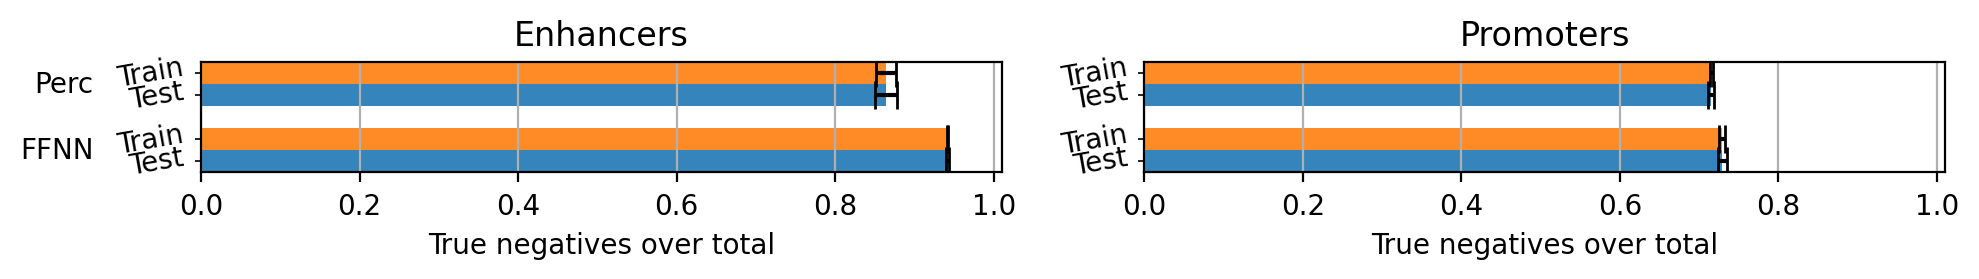

In [23]:
from barplots import barplots

barplots(
    all_binary_classification_performance.drop(columns=["holdout_number"]),
    groupby=["task", "model_name", "run_type"],
    orientation="horizontal",
    height=5,
    subplots=True,
    minor_rotation=10,
    show_legend = False
)